<h2>Preliminaries

In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import constants
import IPython.display as ipd  # To play sound in the notebook
np.random.seed(1001)
import os
from os import listdir
from os.path import isfile, join
import shutil
import IPython
import matplotlib
import seaborn as sns
from scipy.io import wavfile
from sklearn import preprocessing

In [6]:
data_loc="database/"
wav_path = data_loc+"audio_train/"
sr=44100

In [7]:
dataset = pd.read_csv(data_loc+"train.csv",header=0,names=['fname','label','verified'])
checkedDataset = dataset.loc[dataset.verified == 1,["fname","label"]]

In [8]:
# Based on https://www.kaggle.com/codename007/a-very-extensive-freesound-exploratory-analysis?scriptVersionId=3019309
def load_wav_file(name):
    _, b = wavfile.read(wav_path + name)
    assert _ == sr
    return b

checkedDataset['time_series'] = checkedDataset['fname'].apply(load_wav_file)
checkedDataset['nframes'] = checkedDataset['time_series'].apply(len)

In [9]:
print(checkedDataset.shape)
checkedDataset.head()

(3710, 4)


,fname,label,time_series,nframes
1,001ca53d.wav,Saxophone,"[-33, -32, -34, -34, -37, -37, -39, -39, -41, ...",455112
3,0033e230.wav,Glockenspiel,"[0, 10, 39, -66, -49, 29, 4, -57, -133, -158, ...",352800
4,00353774.wav,Cello,"[-173, -162, -172, -142, -170, -139, -139, -13...",199332
6,003da8e5.wav,Knock,"[2, -1, -2, 0, -2, -2, 1, -3, -1, 0, -1, 1, -3...",59976
7,0048fd00.wav,Gunshot_or_gunfire,"[-20, -23, -23, -15, -7, -5, -4, -7, -11, -16,...",45864


In [10]:
def normalize(df):
    # Normalization function
    return (df - df.mean(axis=0)) / (df.std(axis=0))

def encode(data, oneHot=False):
    # Encode labels into integers or onehot
    le = preprocessing.LabelEncoder()
    le.fit(data)
    trans = le.transform(data)
    if oneHot== True:
        ohlen = (len(set(trans)))
        eye=np.eye(ohlen)
        return np.array([eye[i] for i in trans])
    else:
        return trans

<h2>We're going to create 4 different types of audio features here</h2>

In [11]:
"""We're going to create 4 different types of audio features"""
# MFCC 

# Returns normalized mfcc dataset
def getmfcc(df, train=True):
    dset=[]
    audiolen=2*sr
    
    if train==False:
        ddir=data_loc+"audio_test/"
        files=[f for f in listdir(ddir) if isfile(join(ddir, f))]
#         files=[f for f in listdir(ddir)]
    else:
        ddir=wav_path
        files=df.fname.values
    
    for file in files:
        wav,_= librosa.core.load(ddir+file, sr=sr)
        
        # Pad/trim WAV data
        if len(wav) > audiolen:
            wav = wav[:audiolen]
        elif len(wav) < audiolen:
            off=audiolen - len(wav) 
            wav=np.pad(wav, (off, audiolen - len(wav) - off), 'constant')
            
        mfcc = librosa.feature.mfcc(wav, sr = sr, n_mfcc=40)
        dset.append(mfcc)
    
    return (normalize(np.array(dset))) # Return normalized dataset

In [12]:
# Melspectrogram

def getmelspec(df, train=True):
    dset=[]
    audiolen=2*sr
    
    if train==False:
        ddir=data_loc+"audio_test/"
        files=[f for f in listdir(ddir) if isfile(join(ddir, f))]
    else:
        ddir=wav_path
        files=df.fname.values
    
    for file in files:
        wav,_= librosa.core.load(ddir+file, sr=sr)
        
        # Pad/trim WAV data
        if len(wav) > audiolen:
            wav = wav[:audiolen]
        elif len(wav) < audiolen:
            off=audiolen - len(wav) 
            wav=np.pad(wav, (off, audiolen - len(wav) - off), 'constant')
            
        ms = librosa.feature.melspectrogram(wav, sr = sr)
        dset.append(ms)
    
    return (normalize(np.array(dset))) # Return normalized dataset

In [13]:
# CQT
def getcqt(df, train=True):
    dset=[]
    audiolen=2*sr
    
    if train==False:
        ddir=data_loc+"audio_test/"
        files=[f for f in listdir(ddir) if isfile(join(ddir, f))]
    else:
        ddir=wav_path
        files=df.fname.values
    
    for file in files:
        wav,_= librosa.core.load(ddir+file, sr=sr)
        
        # Pad/trim WAV data
        if len(wav) > audiolen:
            wav = wav[:audiolen]
        elif len(wav) < audiolen:
            off=audiolen - len(wav) 
            wav=np.pad(wav, (off, audiolen - len(wav) - off), 'constant')
            
        cqt = librosa.core.cqt(wav, sr = sr)
        dset.append(cqt)
    
    return (normalize(np.array(dset))) # Return normalized dataset

In [14]:
# STFT

def getstft(df, train=True):
    dset=[]
    audiolen=2*sr
    
    if train==False:
        ddir=data_loc+"audio_test/"
        files=[f for f in listdir(ddir) if isfile(join(ddir, f))]
    else:
        ddir=wav_path
        files=df.fname.values
    
    for file in files:
        wav,_= librosa.core.load(ddir+file, sr=sr)
        
        # Pad/trim WAV data
        if len(wav) > audiolen:
            wav = wav[:audiolen]
        elif len(wav) < audiolen:
            off=audiolen - len(wav) 
            wav=np.pad(wav, (off, audiolen - len(wav) - off), 'constant')
            
        stft = librosa.core.stft(wav)
        dset.append(stft)
    
    return (normalize(np.array(dset))) # Return normalized dataset

Now that we have our functions defined for extracting different features, lets first create the datasets

In [15]:
y=encode(checkedDataset.label.values, oneHot=True)

In [16]:
mfcc_train=getmfcc(checkedDataset)
mfcc_test=getmfcc(None, False)

In [17]:
mel_train=getmelspec(checkedDataset)
mel_test=getmelspec(None, False)

In [18]:
cqt_train=getcqt(checkedDataset)
cqt_test=getcqt(None, False)

In [19]:
""" STFT gave memory error :( """

' STFT gave memory error :( '

In [20]:
print(mfcc_train.shape)
print(mel_train.shape)
print(cqt_train.shape)
print(y.shape)

(3710, 40, 173)
(3710, 128, 173)
(3710, 84, 173)
(3710, 41)


<h2> Data loaded! Lets do some visualizations

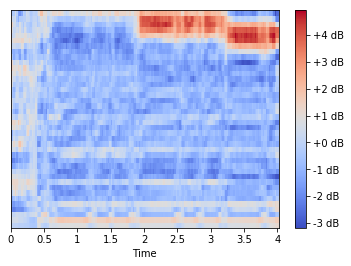

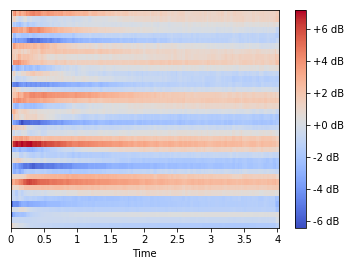

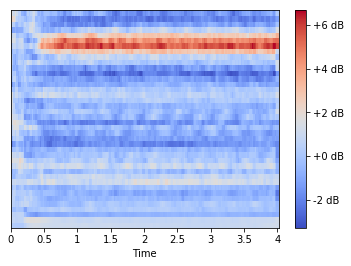

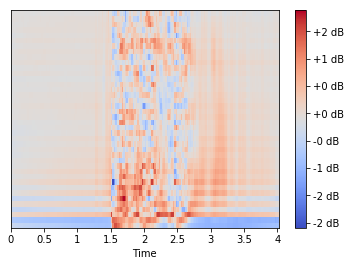

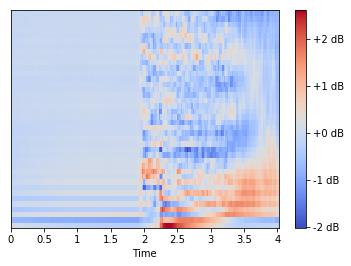

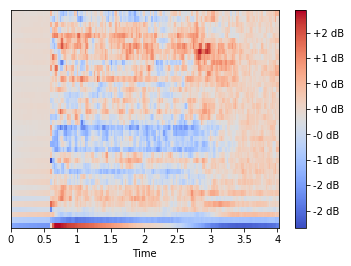

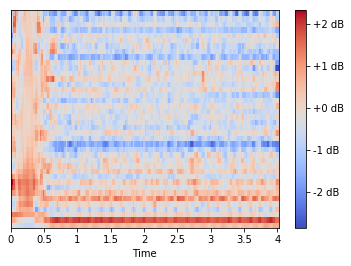

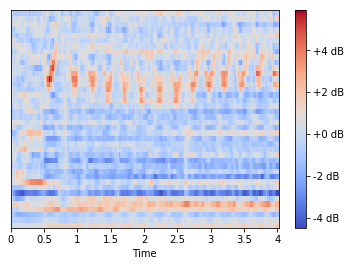

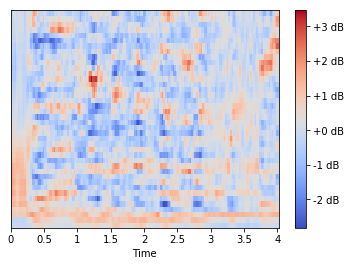

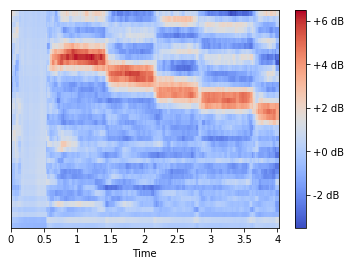

In [40]:
# First, lets check out some MFCCs
from librosa import display

for i in range(10):
#     librosa.display.specshow(librosa.power_to_db(mfcc_train[i], ref=np.max), y_axis='mel')
    librosa.display.specshow(mfcc_train[i], x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

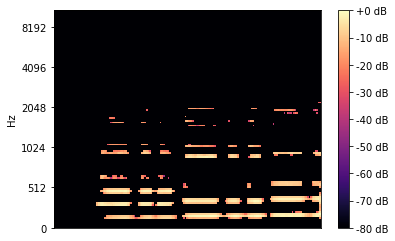

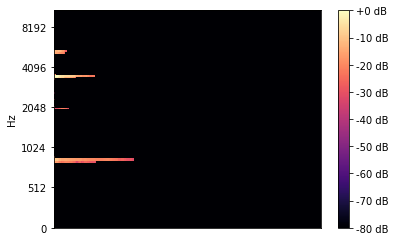

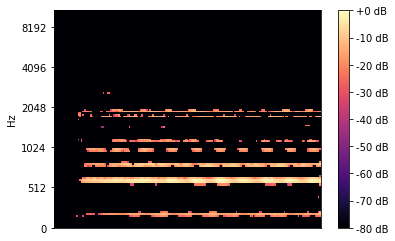

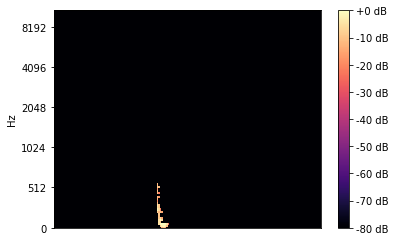

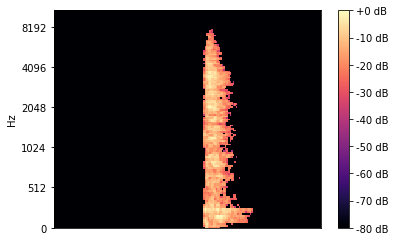

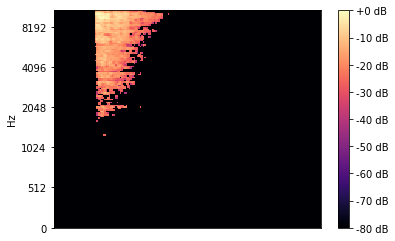

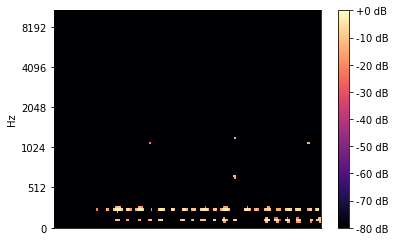

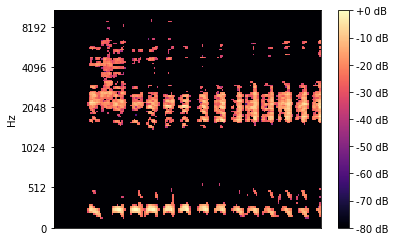

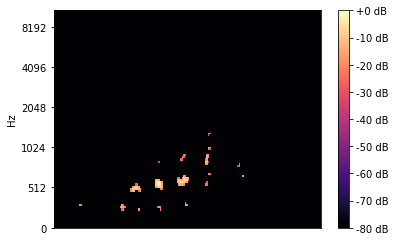

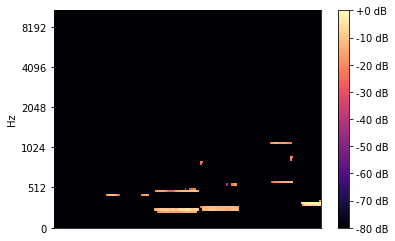

In [22]:
# Do melspectrograms now
for i in range(10):
    librosa.display.specshow(librosa.power_to_db(mel_train[i], ref=np.max), y_axis='mel')
#     librosa.display.specshow(mel_train[i], x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

/home/kenny/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


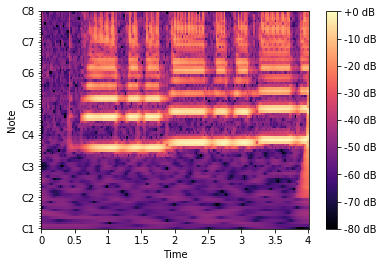

/home/kenny/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


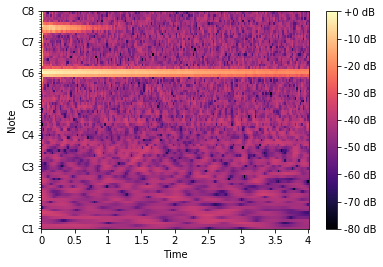

/home/kenny/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


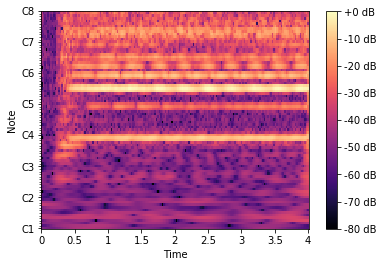

/home/kenny/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


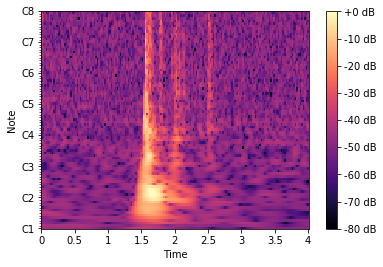

/home/kenny/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


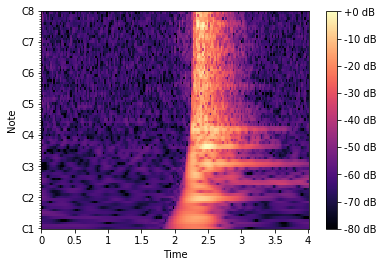

/home/kenny/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


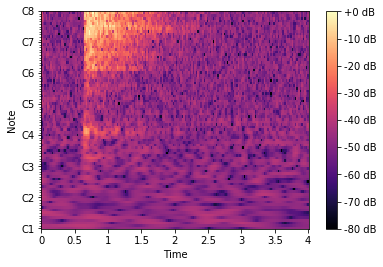

/home/kenny/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


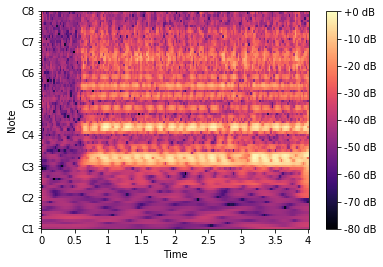

/home/kenny/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


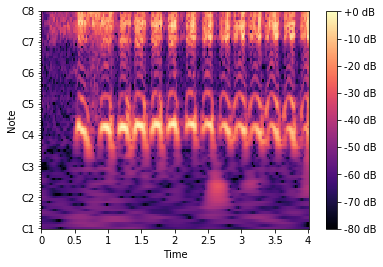

/home/kenny/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


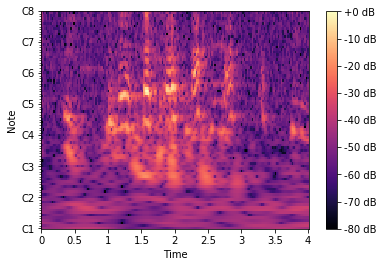

/home/kenny/.local/lib/python3.6/site-packages/librosa/core/spectrum.py:959: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


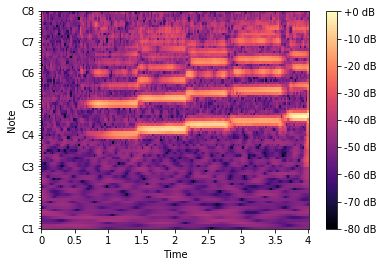

In [23]:
# CQT
for i in range(10):
    librosa.display.specshow(librosa.amplitude_to_db(cqt_train[i], ref=np.max), x_axis='time', y_axis='cqt_note')
#     librosa.display.specshow(cqt_train[i], x_axis='time', y_axis='cqt_note')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [ ]:
# Lets see how the MFCC signals look

<h2> Classifications

In [24]:
# Keras imports
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Embedding, BatchNormalization
from keras.layers import (Convolution1D, GlobalAveragePooling1D, Flatten,
                          GlobalMaxPool1D, MaxPool1D, Flatten, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import LeakyReLU, Bidirectional

Convolutional networks have shown to be promising in audio classification. We will create one here

In [26]:
def tvsplit(x,y,keep):
    # test/validation split
    # trainsz - size of train set to retain; eg 0.7
    trsize=int(x.shape[0] * keep)

    x_train=x[:trsize]
    x_val=x[trsize:] 

    y_train=y[:trsize] 
    y_val=y[trsize:] 
    
    return x_train,x_val,y_train,y_val

In [30]:
xtrms,xvalms,ytrms,yvalms = tvsplit(mel_train,y, 0.8)
xvalcn, xtestcn, yvalcn, ytestcn = tvsplit(xvalms, yvalms, 0.5)

In [27]:
xtrmfcc, xvalmfcc, ytrmfcc, yvalmfcc = tvsplit(mfcc_train, y, 0.8)
xvalmfcc, xtestmfcc, yvalmfcc, ytestmfcc = tvsplit(xvalmfcc, yvalmfcc, 0.8)

In [31]:
cnet = Sequential([
    Convolution1D(128,4, padding="same", input_shape=(xtrms.shape[1], xtrms.shape[2])),
    LeakyReLU(alpha=0.1),
    MaxPool1D(1),
    BatchNormalization(),
    
    Convolution1D(192,4, padding="same"),
    LeakyReLU(alpha=0.3),
    Convolution1D(192,4, padding="same"),
    LeakyReLU(alpha=0.3),
    MaxPool1D(8),
    
    Convolution1D(128,4, padding="same"),
    LeakyReLU(alpha=0.3),
    Convolution1D(128,4, padding="same"),
    LeakyReLU(alpha=0.3),
    MaxPool1D(8),
    BatchNormalization(),
    Flatten(),
#     LSTM(256, activation='relu'),
#     LSTM(256, activation='relu'),
  
#     Bidirectional(LSTM(256)),
    Dense(256),
    LeakyReLU(alpha=0.3),
    Dropout(rate=0.5),
    Dense(100),
    LeakyReLU(alpha=0.3),
    Dropout(rate=0.5),
    Dense(100),
    LeakyReLU(alpha=0.3),
    Dense(41, activation='softmax')
])

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0000001)

early = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=20,\
                      verbose=0, mode='auto')

cnet.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

print (cnet.summary())

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 128, 128)          88704     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 128)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128)          512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 192)          98496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 192)          0         
___________________________________________________________

In [32]:
cnet.fit(xtrms, ytrms,
          batch_size=200, epochs=150,
          validation_data=(xvalcn, yvalcn),
          callbacks=[early, lr_reduction])

Train on 2968 samples, validate on 371 samples
Epoch 1/150
2968/2968 [==============================] - 18s 6ms/step - loss: 3.8196 - acc: 0.0526 - val_loss: 3.7061 - val_acc: 0.1321
Epoch 2/150
2968/2968 [==============================] - 1s 354us/step - loss: 3.5551 - acc: 0.1095 - val_loss: 3.4783 - val_acc: 0.1375
Epoch 3/150
2968/2968 [==============================] - 1s 308us/step - loss: 3.4432 - acc: 0.1247 - val_loss: 3.3537 - val_acc: 0.1725
Epoch 4/150
2968/2968 [==============================] - 1s 333us/step - loss: 3.2813 - acc: 0.1617 - val_loss: 3.2157 - val_acc: 0.1941
Epoch 5/150
2968/2968 [==============================] - 1s 312us/step - loss: 3.1004 - acc: 0.1843 - val_loss: 3.1127 - val_acc: 0.2183
Epoch 6/150
2968/2968 [==============================] - 1s 313us/step - loss: 2.9011 - acc: 0.2156 - val_loss: 2.9682 - val_acc: 0.2210
Epoch 7/150
2968/2968 [==============================] - 1s 331us/step - loss: 2.7217 - acc: 0.2591 - val_loss: 2.9313 - val_acc: 0.

In [46]:
cnetscore = cnet.evaluate(xtestcn, ytestcn, batch_size=150)

print(cnetscore)

371/371 [==============================] - 1s 2ms/step
[2.0300162616123085, 0.5040431204992485]


In [52]:
mfccnet = Sequential([
    Convolution1D(173,4, padding="same", input_shape=(xtrmfcc.shape[1], xtrmfcc.shape[2])),
    LeakyReLU(alpha=0.1),
    MaxPool1D(1),
    BatchNormalization(),
    
    Convolution1D(192,4, padding="same"),
    LeakyReLU(alpha=0.3),
    Convolution1D(192,4, padding="same"),
    LeakyReLU(alpha=0.3),
    MaxPool1D(5),
    
    Convolution1D(128,4, padding="same"),
    LeakyReLU(alpha=0.3),
    Convolution1D(128,4, padding="same"),
    LeakyReLU(alpha=0.3),
    MaxPool1D(8),
    BatchNormalization(),
    Flatten(),
#     LSTM(256, activation='relu'),
#     LSTM(256, activation='relu'),
  
#     Bidirectional(LSTM(256)),
    Dense(256),
    LeakyReLU(alpha=0.3),
    Dropout(rate=0.5),
    Dense(100),
    LeakyReLU(alpha=0.3),
    Dropout(rate=0.5),
    Dense(100),
    LeakyReLU(alpha=0.3),
    Dense(41, activation='softmax')
])

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                patience=10, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=0.0000001)

early = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=20,\
                      verbose=0, mode='auto')

mfccnet.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

print (mfccnet.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 40, 173)           119889    
_________________________________________________________________
leaky_re_lu_103 (LeakyReLU)  (None, 40, 173)           0         
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 40, 173)           0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 40, 173)           692       
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 40, 192)           133056    
_________________________________________________________________
leaky_re_lu_104 (LeakyReLU)  (None, 40, 192)           0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 40, 192)           147648    
__________

In [53]:
mfccnet.fit(xtrmfcc, ytrmfcc,
          batch_size=200, epochs=150,
          validation_data=(xvalmfcc, yvalmfcc),
          callbacks=[early, lr_reduction])

Train on 2968 samples, validate on 593 samples
Epoch 1/150
2968/2968 [==============================] - 2s 813us/step - loss: 3.6487 - acc: 0.0657 - val_loss: 3.3103 - val_acc: 0.0961
Epoch 2/150
2968/2968 [==============================] - 0s 150us/step - loss: 3.2613 - acc: 0.1260 - val_loss: 2.9604 - val_acc: 0.1956
Epoch 3/150
2968/2968 [==============================] - 0s 155us/step - loss: 2.9572 - acc: 0.1914 - val_loss: 2.7016 - val_acc: 0.2782
Epoch 4/150
2968/2968 [==============================] - 0s 90us/step - loss: 2.6714 - acc: 0.2598 - val_loss: 2.5215 - val_acc: 0.3035
Epoch 5/150
2968/2968 [==============================] - 0s 85us/step - loss: 2.3758 - acc: 0.3309 - val_loss: 2.2287 - val_acc: 0.3895
Epoch 6/150
2968/2968 [==============================] - 0s 85us/step - loss: 2.1267 - acc: 0.3892 - val_loss: 2.0886 - val_acc: 0.4081
Epoch 7/150
2968/2968 [==============================] - 0s 120us/step - loss: 1.9273 - acc: 0.4343 - val_loss: 1.9796 - val_acc: 0.43

In [55]:
mfccnet.evaluate(xtestmfcc, ytestmfcc, batch_size=150)

149/149 [==============================] - 0s 680us/step


[2.4994752407073975, 0.5838926434516907]

In [26]:
conv_model4 = Sequential([
    Convolution1D(256,20, padding="same", input_shape=(xtrms.shape[1], xtrms.shape[2]),\
                 activation='relu',strides=1),
    BatchNormalization(),
    MaxPool1D(3),
    
    Convolution1D(256,20, padding="same", input_shape=(xtrms.shape[1], xtrms.shape[2]),\
                 activation='relu',strides=3),
    BatchNormalization(),
    MaxPool1D(3),
    
    Bidirectional(LSTM(256, return_sequences=True)),
    Dense(173, activation='relu'),
    BatchNormalization(),
    
    Convolution1D(128,20, padding="same",strides=3),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(rate=0.3),
    
#     Dense(28, activation='relu'),
    Dense(41, activation='softmax')
    
])
conv_model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
early = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=10,\
                      verbose=0, mode='auto')
print (conv_model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 128, 256)          886016    
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 256)          1024      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 42, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 14, 256)           1310976   
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 256)           1024      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4, 256)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 4, 512)            1050624   
__________

In [28]:
conv_model4.fit(xtrms, ytrms,
          batch_size=200, epochs=150,
          validation_data=(xvalcn, yvalcn),
          callbacks=[early])

Train on 2968 samples, validate on 371 samples
Epoch 1/150
2968/2968 [==============================] - 5s 2ms/step - loss: 3.3431 - acc: 0.1553 - val_loss: 5.7520 - val_acc: 0.1456
Epoch 2/150
2968/2968 [==============================] - 1s 422us/step - loss: 2.5400 - acc: 0.3100 - val_loss: 3.4583 - val_acc: 0.2722
Epoch 3/150
2968/2968 [==============================] - 1s 422us/step - loss: 2.1015 - acc: 0.4228 - val_loss: 3.3935 - val_acc: 0.2695
Epoch 4/150
2968/2968 [==============================] - 1s 427us/step - loss: 1.7351 - acc: 0.5155 - val_loss: 2.9755 - val_acc: 0.2884
Epoch 5/150
2968/2968 [==============================] - 1s 324us/step - loss: 1.5025 - acc: 0.5869 - val_loss: 3.0299 - val_acc: 0.3450
Epoch 6/150
2968/2968 [==============================] - 1s 358us/step - loss: 1.2936 - acc: 0.6600 - val_loss: 3.6643 - val_acc: 0.2938
Epoch 7/150
2968/2968 [==============================] - 1s 389us/step - loss: 1.1603 - acc: 0.6867 - val_loss: 2.7994 - val_acc: 0.3

In [30]:
conv_model4.evaluate(xtestcn, ytestcn, batch_size=150)

371/371 [==============================] - 0s 281us/step


[2.8617468799220904, 0.4016172545296805]